<a href="https://colab.research.google.com/github/achalgarg14/session_4/blob/main/Session_4_Assignment_Code_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attempt 3:
##Target:

* Lower number of parameters (Meet our target of <=10000 Parameters)
* Add Transformations to make model invariant to brightness and rotation
* Use Step Learning to stablize results

##Results:

* Total Parameters: 9,752
* Best Training Accuracy: 99.34%
* Best Test Accuracy: 99.53%

##Analysis:

* Model was able to achieve it's target of 99.40% accuracy at 7th epoch and remained more than 99.40% after that.
* Adding transformations like Random Rotation & Color Jitter helped the model to learn better and become more resilient.
* Step Learning with higher starting learning rate of and decent step size helped the model in learning fast and stabilizing accuracy in later stages.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Reducing parameters below 10k

In [ ]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26  RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24  RF = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24  RF = 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12  RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10  RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8  RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6  RF = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6  RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1  RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1  RF = 32


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#Training and Testing of our model

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


Loss=0.07391320914030075 Batch_id=468 Accuracy=94.33: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]



Test set: Average loss: 0.0486, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss=0.0462663359940052 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:30<00:00, 15.36it/s]



Test set: Average loss: 0.0266, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.04418739676475525 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]



Test set: Average loss: 0.0326, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.03411662206053734 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.00566829415038228 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:30<00:00, 15.23it/s]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 6


Loss=0.045117247849702835 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:31<00:00, 15.07it/s]



Test set: Average loss: 0.0237, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.01531552616506815 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]



Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Loss=0.0597345344722271 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:34<00:00, 13.48it/s]



Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)

EPOCH: 9


Loss=0.02392672188580036 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s]



Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.023226318880915642 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s]



Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

EPOCH: 11


Loss=0.012992667965590954 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]



Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.022751634940505028 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]



Test set: Average loss: 0.0157, Accuracy: 9953/10000 (99.53%)

EPOCH: 13


Loss=0.00044503118260763586 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:31<00:00, 15.11it/s]



Test set: Average loss: 0.0153, Accuracy: 9953/10000 (99.53%)

EPOCH: 14


Loss=0.05361214280128479 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]



Test set: Average loss: 0.0153, Accuracy: 9952/10000 (99.52%)

EPOCH: 15


Loss=0.005725249648094177 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s]



Test set: Average loss: 0.0155, Accuracy: 9949/10000 (99.49%)



# Plotting Accuracy and Loss Graphs


In [ ]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

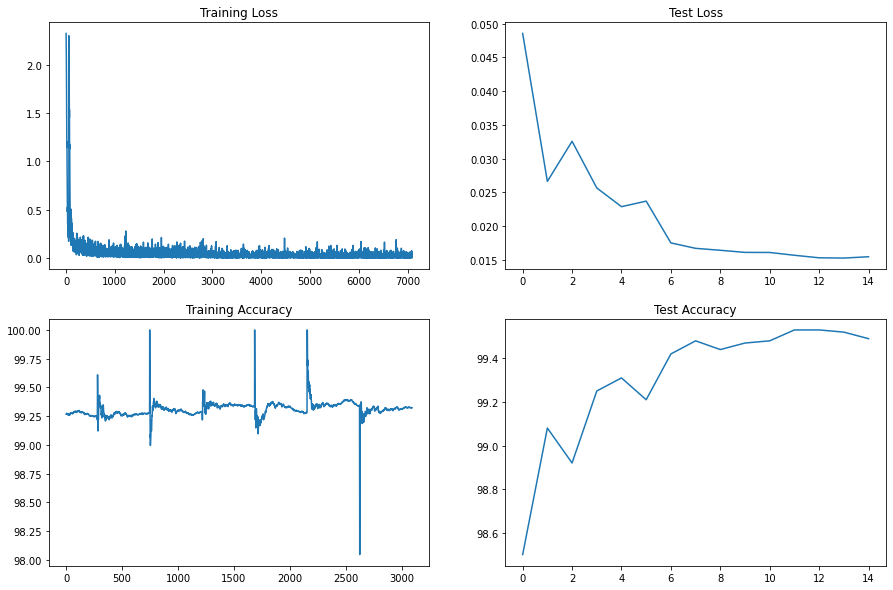

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")